In [150]:
# import basic libraries
import os
import json
import numpy as np
import pandas as pd
import re
import random
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
import pyperclip
from sklearn.cluster import KMeans

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [153]:
file_data = json.load(open(os.path.expanduser("~/ServiceAccountsKey.json")))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

liber_naturae_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1pplxADxNZ3CS7cI6IU1RvfUNi8gIEZmjf-QIwYIFK-w/edit?usp=sharing")

In [3]:
from transformers import AutoModel, AutoTokenizer
from transformers import PreTrainedTokenizer

In [5]:
#from cltk.tokenizers.lat.lat import LatinWordTokenizer as WordTokenizer
#from cltk.tokenizers.lat.lat import LatinPunktSentenceTokenizer as SentenceTokenizer
from tensor2tensor.data_generators import text_encoder

* install gdown python library for downloading large files from google drive
* ensure you are in the desired location
* run `gdown "https://drive.google.com/uc?id=1Te_14UB-DZ8wYPhHGyDg7LadDTjNzpti"`
* create a directory for the model where you wish, e.g.: `mkdir -p /srv/models/latin-bert` it might require `sudo`; if the dir is in your repo,  check that you have this path in .gitignore
* unarchive the model to the directory you created: `tar -xf latin_bert.tar --strip-components 1 -C /srv/models/latin-bert`
* download subword tokenizer: `curl -L -o /srv/models/latin-bert/latin.subword.encoder https://github.com/dbamman/latin-bert/raw/master/models/subword_tokenizer_latin/latin.subword.encoder`
* remove the archive you first downloaded: `rm -rf latin_bert.tar`

In [6]:
# Initialize the tokenizer with the vocab.txt file and the encoder
vocab_file_path = "/srv/models/latin-bert/vocab.txt" # "/Users/vojtechkase/Projects/latin-bert/models/latin_bert/vocab.txt"  # Update this path
tokenizer_path = "/srv/models/latin-bert/latin.subword.encoder"
# Update this path
encoder = text_encoder.SubwordTextEncoder(tokenizer_path)

from latin_tokenizer import LatinTokenizer
tokenizer = LatinTokenizer(vocab_file_path, encoder)

In [7]:
model = AutoModel.from_pretrained("/srv/models/latin-bert/")

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to GPU
model = model.to(device)

In [9]:
sent = "verum ex libro naturae nos hausimus aliqualem illam conformitatem in facultatibus à seminum & aliarum partium similitudine."
input_ids = tokenizer.encode(sent)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

['verum_', 'ex', 'libro_', 'naturae_', 'nos', 'hausi', 'mus_', 'aliqua', 'lem_', 'illam_', 'conformi', 'tatem_', 'in', 'facultatibus_', 'à', 'semi', 'num_', '&', 'aliarum_', 'partium_', 'similit', 'udin', 'e_', '._']


In [10]:
inputs = tokenizer(sent, return_tensors='pt', padding=True, truncation=True, max_length=512, return_offsets_mapping=True)
input_ids = inputs['input_ids']
input_ids[0][:20] #bert_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

tensor([  358,  3641,   651,   601,  4879, 22997,   104, 14893,   649,   557,
        19933,   654,  7556, 26072,  5882,  1950,   310, 31547,  5667,  3464])

# Loading and processing Noscemus textual data

In [11]:
metadata_table_long = pd.read_json("https://raw.githubusercontent.com/CCS-ZCU/noscemus_ETF/master/data/metadata_table_long.json")
# or, if you have noscemus_ETF repository somewhere....
metadata_table_long.head(5)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,ids,id,date_min,date_max,filename,file_year,sents_n,tokens_n,disciplines_list,science_class
0,"Achrelius, Daniel",Scientiarum magnes recitatus publice anno 1690...,None,1690,[Turku],Wall,17th century,Oration,"Mathematics, Astronomy/Astrology/Cosmography, ...",Scientiarum magnes(Google Books),...,[705665],705665,1690.0,1690.0,"Achrelius,_Daniel_-_Scientiarum_magnes__Turku_...",1690.0,630,8839,"[Mathematics, Astronomy/Astrology/Cosmography,...",mixture
1,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,[801745],801745,1603.0,1603.0,Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...,1603.0,6527,82445,[Astronomy/Astrology/Cosmography],exact_sciences
2,"Acosta, José de",De natura novi orbis libri duo et De promulgat...,None,1589,Salamanca,Guillelum Foquel,16th century,Monograph,"Astronomy/Astrology/Cosmography, Geography/Car...",De natura novi orbis(Biodiversity Heritage Lib...,...,[713323],713323,1589.0,1589.0,"Acosta,_José_de_-_De_natura_novi_orbis__Salama...",1589.0,8905,170205,"[Astronomy/Astrology/Cosmography, Geography/Ca...",exact_sciences
3,"Adam, Melchior","Vitae Germanorum medicorum, qui saeculo superi...",None,1620,Heidelberg,"Rosa, Geyder",17th century,Biography,Medicine,Vitae Germanorum medicorum(MDZ)Alternative lin...,...,[693148],693148,1620.0,1620.0,"Adam,_Melchior_-_Vitae_Germanorum_medicorum__H...",1620.0,17961,193272,[Medicine],life_sciences
4,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0,3533,47878,[Meteorology/Earth sciences],exact_sciences


In [14]:
id_year_dict = dict(zip(metadata_table_long["id"].astype(str), metadata_table_long["file_year"]))

In [15]:
id_author_dict = dict(zip(metadata_table_long["id"].astype(str), metadata_table_long["Author"].apply(lambda x: x.partition(",")[0])))

In [16]:
def get_sentence_data(target_lemma, path="/srv/data/tome/noscemus/sents_data/"):
    target_sentences = []  
    fns = os.listdir(path)
    for fn in fns:
        sents_data = pickle.load(open(path + fn, "rb"))
        for sent_n, (sent_text, sent_data) in enumerate(sents_data):
            lemmata = [tup[1] for tup in sent_data]
            if target_lemma in lemmata:
                sent_data = sents_data[sent_n]
                target_sentences.append((fn, sent_n, sent_data[0], sent_data[1]))
    return target_sentences

In [17]:
%%time
tar_sents = get_sentence_data("liber")

CPU times: user 1min 31s, sys: 828 ms, total: 1min 32s
Wall time: 1min 32s


In [18]:
len(tar_sents)

181019

In [19]:
tar_sents_nouns = []
for sent_data in tar_sents:
    if [tup for tup in sent_data[3] if (tup[1]=="liber") & (tup[2]=="NOUN")]:
        tar_sents_nouns.append(sent_data)    

In [20]:
len(tar_sents_nouns)

166203

In [21]:
sents_meta = [sent_data for sent_data in tar_sents if re.search(r"lib\w{2,3} natura",  sent_data[2])]
sents_meta[:5]

[('704336.pickle',
  29989,
  'omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:',
  [('omnes', 'omnis', 'DET', (0, 5)),
   ('hi', 'hic', 'DET', (6, 8)),
   ('cum', 'cum', 'ADP', (9, 12)),
   ('lanne', '', 'NOUN', (13, 18)),
   ('&', '&', 'PUNCT', (19, 20)),
   ('Mambre', '', 'PROPN', (21, 27)),
   ('et', 'et', 'CCONJ', (28, 30)),
   ('Simone', 'Simo', 'PROPN', (31, 37)),
   ('mago', 'magus', 'NOUN', (38, 42)),
   ('aeternis', 'aeternus', 'ADJ', (43, 51)),
   ('ignibus', 'ignis', 'NOUN', (52, 59)),
   ('cruciandi', 'crucio', 'VERB', (60, 69)),
   ('destinabuntur', 'destino', 'VERB', (70, 83)),
   ('.', '.', 'PUNCT', (83, 84)),
   ('99', '99', 'NUM', (85, 87)),
   ('In', 'in', 'ADP', (88, 90)),
   ('primo', 'primus', 'ADJ', (91, 96)),
   ('libro', 'liber', 'NOUN', (97, 102)),
   ('naturalis', 'naturalis', 'ADJ', (103, 112)),
   ('magia', 'magia', 'NOU

In [22]:
len(sents_meta)

154

In [133]:
with open("../data/liber_sents_data.json", "w") as f:
    json.dump(sents_meta, f)

,0,1,2
0,704336,29989,omnes hi cum lanne & Mambre et Simone mago aet...
1,704336,36271,"librum naturalis historiae, quo Catholicam syd..."
2,704336,37417,Scholia quaedam in secundum C. Plinii librum n...
3,704336,62315,Ad utilitatem & salutem omnium Christianorum s...
4,704338,33089,"tus liber, a Philippo Clerico ex Arabi De prob..."
...,...,...,...
149,702835,6005,"de generatione & corruptione, & consequenter e..."
150,718447,200,"puta liber naturae, & liber Scripturae."
151,718447,210,Nam experientia pertinet ad librum naturae.
152,718447,2409,"Persequamur itaque has decem partes, duce Scri..."


# Generating embeddings

In [23]:
def get_decontextualized_embeddings(word: str):
    input_ids = tokenizer.encode(word) # , add_special_tokens=False)
    input_ids_tensor = torch.LongTensor(input_ids).to(device)  # Move to GPU
    word_emb = model.get_input_embeddings()
    embeddings = word_emb(input_ids_tensor)
    return embeddings.mean(0).cpu().detach().numpy()

def compute_offsets(text, tokens):
    """
    Compute character offsets for each token in the original text.
    """
    offsets = []
    current_pos = 0
    for token in tokens:
        # Handle leading spaces and special characters
        token = token.replace("Ġ", "")
        start_idx = text.find(token, current_pos)
        if start_idx == -1:
            # Token not found, possibly a split token or special case
            # Attempt to find token by removing special characters
            cleaned_token = token.replace('_', '')
            start_idx = text.find(cleaned_token, current_pos)
            if start_idx != -1:
                end_idx = start_idx + len(cleaned_token)
                offsets.append((start_idx, end_idx))
                current_pos = end_idx
            else:
                # If still not found, append a dummy offset
                offsets.append((current_pos, current_pos + len(token)))
        else:
            end_idx = start_idx + len(token)
            offsets.append((start_idx, end_idx))
            current_pos = end_idx

    return offsets
    
def get_embeddings_data(sent, tokenized_data):
    sent = sent.lower()
    # Tokenize and prepare input tensors
    inputs = tokenizer(sent, return_tensors='pt', padding=True, truncation=True, max_length=512) #return_offsets_mapping=True)

    input_ids_tensor = inputs['input_ids'].to(device)  # Move to GPU
    attention_mask_tensor = inputs.get('attention_mask', torch.ones_like(input_ids_tensor)).to(device)  # Move to GPU

    # Convert input IDs to tokens
    bert_tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor[0].tolist())
    offset_mapping = compute_offsets(sent, bert_tokens)

    # Model forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        last_hidden_state = outputs.last_hidden_state
        bert_sentence_embeddings = last_hidden_state.mean(dim=1).squeeze().cpu().detach().numpy()  # Move back to CPU
        bert_token_embeddings = last_hidden_state[0].cpu().detach().numpy()  # Move back to CPU

    # Prepare tokens data for comparison
    tokens_data_updated = [(token, offset, embedding) for token, offset, embedding in zip(bert_tokens, offset_mapping, bert_token_embeddings)]

    covered_tups = []
    for word_tuple in tokenized_data:
        start_offset, end_offset = word_tuple[-1]
    
        # Extract covered tokens and embeddings
        covered_tokens = [tup[0] for tup in tokens_data_updated if start_offset <= tup[1][0] < end_offset]
        covered_embeddings = [tup[2] for tup in tokens_data_updated if start_offset <= tup[1][0] < end_offset]
    
        # Compute average embedding
        if covered_embeddings:
            embedding_avg = np.mean(covered_embeddings, axis=0)
        else:
            embedding_avg = np.zeros(768)
    
        # Decontextualized embedding
        embedding_decontext = get_decontextualized_embeddings(word_tuple[0])
    
        # Compute similarity score
        embedding_avg_2d = embedding_avg.reshape(1, -1)
        embedding_decontext_2d = embedding_decontext.reshape(1, -1)
        if np.isnan(embedding_avg).any() or np.isnan(embedding_decontext).any():
            similarity_score = None
        else:
            similarity_score = cosine_similarity(embedding_avg_2d, embedding_decontext_2d)[0, 0]
    
        # Append to results
        covered_tups.append((
            word_tuple[0],    # spacy_tokens
            word_tuple[1],    # spacy_lemma
            word_tuple[2],    # spacy_pos
            word_tuple[3],    # spacy_position
            covered_tokens,   # bert_tokens
            covered_embeddings, # bert_tok_emb
            embedding_avg.tolist(),   # Convert numpy array to list
            embedding_decontext.tolist(), # Convert numpy array to list
            similarity_score # cos_sim
        ))
    
    # Create DataFrame
    df = pd.DataFrame(covered_tups, columns=[
        "spacy_tokens", "spacy_lemma", "spacy_pos", "spacy_position",
        "bert_tokens", "bert_tok_emb", "bert_avg_emb", "bert_avg_decontext", "cos_sim"
    ])

    return bert_sentence_embeddings, df

In [24]:
sent_n = 8
sent = sents_meta[sent_n][2].lower()
tokenized_data = sents_meta[sent_n][3]
sent

'formarum autem seu imaginum, quas ciere duo imaginum intus anima solet, duo promptuaria esse libro naturalium sexto auicenna tradit, thesauros formarum uocans:'

In [25]:
inputs = tokenizer(sent, return_tensors='pt', padding=True, truncation=True, max_length=512) #return_offsets_mapping=True)
inputs

{'input_ids': tensor([[26026, 29372,  4693, 19351,    27,     7,  5998,  4547,    59, 12911,
          19351,    27,  2069,  5544,  1246,     7, 12911, 20453,  2286,  3511,
            651, 18070,  3607,  4181,  4143,   328,  4906,     7, 13062,    14,
          26026,  8262,   118,    17,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,    

In [26]:
input_ids = tokenizer.encode(sent)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
tokens

['formarum_',
 'autem',
 'seu',
 'imagin',
 'um_',
 ',_',
 'quas',
 'cie',
 're_',
 'duo',
 'imagin',
 'um_',
 'intus_',
 'anima',
 'solet_',
 ',_',
 'duo',
 'promptu',
 'aria_',
 'esse',
 'libro_',
 'naturalium_',
 'sexto_',
 'aui',
 'cen',
 'na_',
 'tradit_',
 ',_',
 'thesauro',
 's_',
 'formarum_',
 'uoca',
 'ns_',
 ':_']

In [27]:
sentence_emb, df = get_embeddings_data(sent.lower(), tokenized_data)
df

,spacy_tokens,spacy_lemma,spacy_pos,spacy_position,bert_tokens,bert_tok_emb,bert_avg_emb,bert_avg_decontext,cos_sim
0,Formarum,forma,NOUN,"(0, 8)",[formarum_],"[[-0.20829445, 0.031757616, -0.51340127, -1.04...","[-0.20829445123672485, 0.03175761550664902, -0...","[0.016585184261202812, 0.020179441198706627, 0...",0.003001
1,autem,autem,PART,"(9, 14)",[autem],"[[-0.08150536, 0.23882027, -0.4995009, -0.9636...","[-0.08150535821914673, 0.23882026970386505, -0...","[-0.014049533754587173, 0.021155113354325294, ...",0.054632
2,seu,siue,CCONJ,"(15, 18)",[seu],"[[-0.28463143, 0.03610304, -0.5325649, -1.2378...","[-0.2846314311027527, 0.03610303997993469, -0....","[0.00481478963047266, 0.05346470698714256, 0.0...",0.067727
3,imaginum,imago,NOUN,"(19, 27)","[imagin, um_]","[[-0.15180127, 0.17181236, -0.36701635, -1.088...","[-0.18889157474040985, -0.08048081398010254, -...","[-0.022967496886849403, -0.017286483198404312,...",0.108898
4,",",",",PUNCT,"(27, 28)","[,_]","[[-0.37807813, 0.08207306, -0.361526, -0.90419...","[-0.3780781328678131, 0.08207306265830994, -0....","[0.030093882232904434, -0.11158721148967743, 0...",-0.002513
5,quas,qui,PRON,"(29, 33)",[quas],"[[-0.41710067, 0.22542909, -0.5227048, -0.7535...","[-0.4171006679534912, 0.22542908787727356, -0....","[0.03181392699480057, 0.05044538527727127, -0....",0.081098
6,ciere,cio,VERB,"(34, 39)","[cie, re_]","[[-0.3754464, 0.16404082, -0.22233184, -1.1980...","[-0.4217323958873749, -0.09993498772382736, -0...","[-0.02245941571891308, -0.0028409836813807487,...",0.086106
7,Duo,duo,NUM,"(40, 43)",[duo],"[[-0.15817012, 0.20905748, -0.18637536, -0.845...","[-0.15817011892795563, 0.20905748009681702, -0...","[0.0001504796091467142, -0.01530927512794733, ...",-0.007727
8,imaginum,imago,NOUN,"(44, 52)","[imagin, um_]","[[-0.49140093, 0.14554639, -0.36095184, -1.180...","[-0.41664379835128784, -0.12452796846628189, -...","[-0.022967496886849403, -0.017286483198404312,...",0.112207
9,intus,intus,ADV,"(53, 58)",[intus_],"[[-0.3340109, 0.057889864, -0.0776725, -0.5421...","[-0.33401089906692505, 0.05788986384868622, -0...","[-0.014142806641757488, 0.0868648812174797, -0...",0.084746


In [72]:
n = 2000
tar_sents_sample = random.sample(tar_sents, n)

In [73]:
sents_meta[0]

('704336.pickle',
 29989,
 'omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:',
 [('omnes', 'omnis', 'DET', (0, 5)),
  ('hi', 'hic', 'DET', (6, 8)),
  ('cum', 'cum', 'ADP', (9, 12)),
  ('lanne', '', 'NOUN', (13, 18)),
  ('&', '&', 'PUNCT', (19, 20)),
  ('Mambre', '', 'PROPN', (21, 27)),
  ('et', 'et', 'CCONJ', (28, 30)),
  ('Simone', 'Simo', 'PROPN', (31, 37)),
  ('mago', 'magus', 'NOUN', (38, 42)),
  ('aeternis', 'aeternus', 'ADJ', (43, 51)),
  ('ignibus', 'ignis', 'NOUN', (52, 59)),
  ('cruciandi', 'crucio', 'VERB', (60, 69)),
  ('destinabuntur', 'destino', 'VERB', (70, 83)),
  ('.', '.', 'PUNCT', (83, 84)),
  ('99', '99', 'NUM', (85, 87)),
  ('In', 'in', 'ADP', (88, 90)),
  ('primo', 'primus', 'ADJ', (91, 96)),
  ('libro', 'liber', 'NOUN', (97, 102)),
  ('naturalis', 'naturalis', 'ADJ', (103, 112)),
  ('magia', 'magia', 'NOUN', (113, 118)),
  ('tr

In [74]:
%%time
sents_dfs = []
for sent_data in sents_meta + tar_sents_sample:
    sent_emb, df = get_embeddings_data(sent_data[2], sent_data[3])
    sents_dfs.append((sent_data[0], sent_data[1], sent_data[2], sent_emb, df))

CPU times: user 43.8 s, sys: 25.2 ms, total: 43.8 s
Wall time: 43.8 s


In [75]:
type(list(id_year_dict.keys())[0])

str

In [76]:
len(id_year_dict)

975

In [77]:
ids = [s[0].partition(".")[0] for s in sents_dfs]
years = [id_year_dict[id] if id in id_year_dict.keys() else None for id in ids]
years[:10]

[1545.0,
 1545.0,
 1545.0,
 1545.0,
 1548.0,
 1696.0,
 1530.0,
 1534.0,
 1522.0,
 1522.0]

In [78]:
authors = [id_author_dict[id] if id in id_author_dict.keys() else None for id in ids]
authors[:10]

['Gessner',
 'Gessner',
 'Gessner',
 'Gessner',
 'Gessner',
 'Baglivi',
 'Brunfels',
 'Brunfels',
 'Vadianus',
 'Vadianus']

In [79]:
sents_dfs[0][4]

,spacy_tokens,spacy_lemma,spacy_pos,spacy_position,bert_tokens,bert_tok_emb,bert_avg_emb,bert_avg_decontext,cos_sim
0,omnes,omnis,DET,"(0, 5)",[omnes_],"[[-0.2267545, 0.03534043, -0.57197773, -0.8987...","[-0.22675450146198273, 0.03534042835235596, -0...","[-0.012650368735194206, 0.03062467835843563, -...",0.016544
1,hi,hic,DET,"(6, 8)",[hi],"[[0.065882646, 0.15884511, -0.29995036, -0.766...","[0.06588264554738998, 0.15884511172771454, -0....","[0.05322127416729927, -0.01336828712373972, -0...",0.089138
2,cum,cum,ADP,"(9, 12)",[cum],"[[-0.078728326, 0.013177161, -0.32417047, -1.1...","[-0.0787283256649971, 0.013177161104977131, -0...","[0.05187046155333519, -0.02129324898123741, 0....",0.014447
3,lanne,,NOUN,"(13, 18)","[lan, ne_]","[[-0.5393002, 0.017649591, -0.66978925, -1.107...","[-0.47358882427215576, -0.15611495077610016, -...","[0.000102214515209198, 0.019755538552999496, -...",0.086808
4,&,&,PUNCT,"(19, 20)",[&],"[[-0.098285615, 0.25577477, -0.37196028, -0.89...","[-0.09828561544418335, 0.25577476620674133, -0...","[0.053975727409124374, 0.02921023964881897, -0...",0.005627
5,Mambre,,PROPN,"(21, 27)","[mam, bre_]","[[-0.11211276, 0.24862047, -0.40294325, -1.211...","[-0.29018062353134155, 0.20940619707107544, -0...","[-0.005745686125010252, -0.022986212745308876,...",0.003742
6,et,et,CCONJ,"(28, 30)",[et],"[[-0.18621594, 0.017778393, -0.23182139, -1.04...","[-0.18621593713760376, 0.017778392881155014, -...","[0.023676078766584396, -0.015391281805932522, ...",0.065091
7,Simone,Simo,PROPN,"(31, 37)","[simo, ne_]","[[-0.5339989, 0.17992054, -0.07132285, -0.8835...","[-0.5432291626930237, -0.11695485562086105, -0...","[0.027885613963007927, -0.0015635404270142317,...",0.022789
8,mago,magus,NOUN,"(38, 42)",[mago],"[[-0.103658386, 0.119519696, -0.38165584, -0.6...","[-0.10365838557481766, 0.11951969563961029, -0...","[0.09494044631719589, -0.025257257744669914, 0...",0.058823
9,aeternis,aeternus,ADJ,"(43, 51)","[aeterni, s_]","[[-0.5825693, 0.15036915, -0.29319075, -1.0211...","[-0.5024323463439941, -0.09176509827375412, -0...","[-0.01861829124391079, 0.029625626280903816, -...",0.126318


In [80]:
sents_meta[0]

('704336.pickle',
 29989,
 'omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:',
 [('omnes', 'omnis', 'DET', (0, 5)),
  ('hi', 'hic', 'DET', (6, 8)),
  ('cum', 'cum', 'ADP', (9, 12)),
  ('lanne', '', 'NOUN', (13, 18)),
  ('&', '&', 'PUNCT', (19, 20)),
  ('Mambre', '', 'PROPN', (21, 27)),
  ('et', 'et', 'CCONJ', (28, 30)),
  ('Simone', 'Simo', 'PROPN', (31, 37)),
  ('mago', 'magus', 'NOUN', (38, 42)),
  ('aeternis', 'aeternus', 'ADJ', (43, 51)),
  ('ignibus', 'ignis', 'NOUN', (52, 59)),
  ('cruciandi', 'crucio', 'VERB', (60, 69)),
  ('destinabuntur', 'destino', 'VERB', (70, 83)),
  ('.', '.', 'PUNCT', (83, 84)),
  ('99', '99', 'NUM', (85, 87)),
  ('In', 'in', 'ADP', (88, 90)),
  ('primo', 'primus', 'ADJ', (91, 96)),
  ('libro', 'liber', 'NOUN', (97, 102)),
  ('naturalis', 'naturalis', 'ADJ', (103, 112)),
  ('magia', 'magia', 'NOUN', (113, 118)),
  ('tr

In [81]:
sentences = [sent_data[2] for sent_data in sents_dfs]
sentences[:3]

['omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:',
 'librum naturalis historiae, quo Catholicam syderum septem, aliaque astronomica & geographica toto sparsa opere tractauit, si quis uel aetate nostra, uel superiori enarrarit ignoro, &c. Post haec de antiqua astronomia Plinii disserit, & de uitiatis codicibus:',
 'Scholia quaedam in secundum C. Plinii librum naturalis historiae, impressa Basileae apud Hen.']

In [82]:
def insert_newlines(input_str, word_count=10):
    words = input_str.split(' ')
    for i in range(word_count - 1, len(words), word_count):
        words[i] = words[i] + '<br>'
    return ' '.join(words)

In [83]:
hover_text = [insert_newlines(sent) + " ({0} {1})".format(author, str(year)) for sent, author, year in zip(sentences, authors, years)]
print(hover_text[:10])

['omnes hi cum lanne & Mambre et Simone mago aeternis<br> ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur,<br> quae multa sane cognitu pulchra & iucun da lectu continet:<br> (Gessner 1545.0)', 'librum naturalis historiae, quo Catholicam syderum septem, aliaque astronomica &<br> geographica toto sparsa opere tractauit, si quis uel aetate nostra,<br> uel superiori enarrarit ignoro, &c. Post haec de antiqua astronomia<br> Plinii disserit, & de uitiatis codicibus: (Gessner 1545.0)', 'Scholia quaedam in secundum C. Plinii librum naturalis historiae, impressa<br> Basileae apud Hen. (Gessner 1545.0)', 'Ad utilitatem & salutem omnium Christianorum sequice tur scientia libri<br> creaturarum, siue libri naturae, & scientia de homine, quae est<br> proce pria homini in quantum homo est: (Gessner 1545.0)', 'tus liber, a Philippo Clerico ex Arabi De problematibus rerum,<br> Solinus, co in Latinum sermonem translatus De mirabilibus naturae Pub.<br> (Gessner 1548.0)', 'De m

In [ ]:
sents_meta_df = pd.DataFrame([(fn.rpartition(".")[0], index, sent) for fn, index, sent, sent_data in sents_meta])

2154

In [ ]:
sents_meta_df

In [148]:
sents_meta_df = pd.DataFrame([(fn.rpartition(".")[0], index, sent) for fn, index, sent, sent_data in sents_meta])
sents_meta_df["author"] = authors[:len(sents_meta_df)]
sents_meta_df["year"] = years[:len(sents_meta_df)]
sents_meta_df.sort_values("year", ascending=True, inplace=True)
sents_meta_df.head(5)

,0,1,2,author,year
31,637738,214,Argumentum affers quam obrem alteram ab altera...,Leoniceno,1509.0
87,841475,11568,Colligit Aristoteles libro naturalium tertio s...,Pio,1514.0
89,841475,31362,Sanctaria scrinia & secretiora repositoria Pli...,Pio,1514.0
88,841475,24338,lege Senecam libro naturaliu primo.,Pio,1514.0
91,841475,55017,"phantida foeminae, quam multa composuit, nomen...",Pio,1514.0


In [154]:
#sents_meta_df.to_csv("../data/sents_meta_df.csv", index=False)
set_with_dataframe(liber_naturae_gs.add_worksheet("sents_meta_df_v1", 1,1), sents_meta_df)

In [84]:
target = "liber"
target_vectors = [] 
for sent_data in sents_dfs:
    df = sent_data[4]
    target_row = df.loc[df["spacy_lemma"] == target].iloc[0]
    target_vectors.append(target_row['bert_avg_emb'])

In [85]:
target_embeddings = np.vstack(target_vectors)
cosine_sim_matrix = pd.DataFrame(cosine_similarity(target_embeddings), index=sentences, columns=sentences)

In [86]:
cosine_sim_matrix.iloc[0].sort_values(ascending=False)

omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [87]:
tsne = TSNE(n_components=1, perplexity=10)
embeddings_tsne = tsne.fit_transform(target_embeddings)

In [88]:
tsne = TSNE(n_components=2, perplexity=40)
embeddings_tsne2d = tsne.fit_transform(target_embeddings)

In [89]:
len(embeddings_tsne2d)

2154

In [90]:
len(years)

2154

In [91]:
colors = ["red"] * len(sents_meta) + ["green"] * len(tar_sents_sample)
len(colors)

2154

(1450.0, 1750.0)

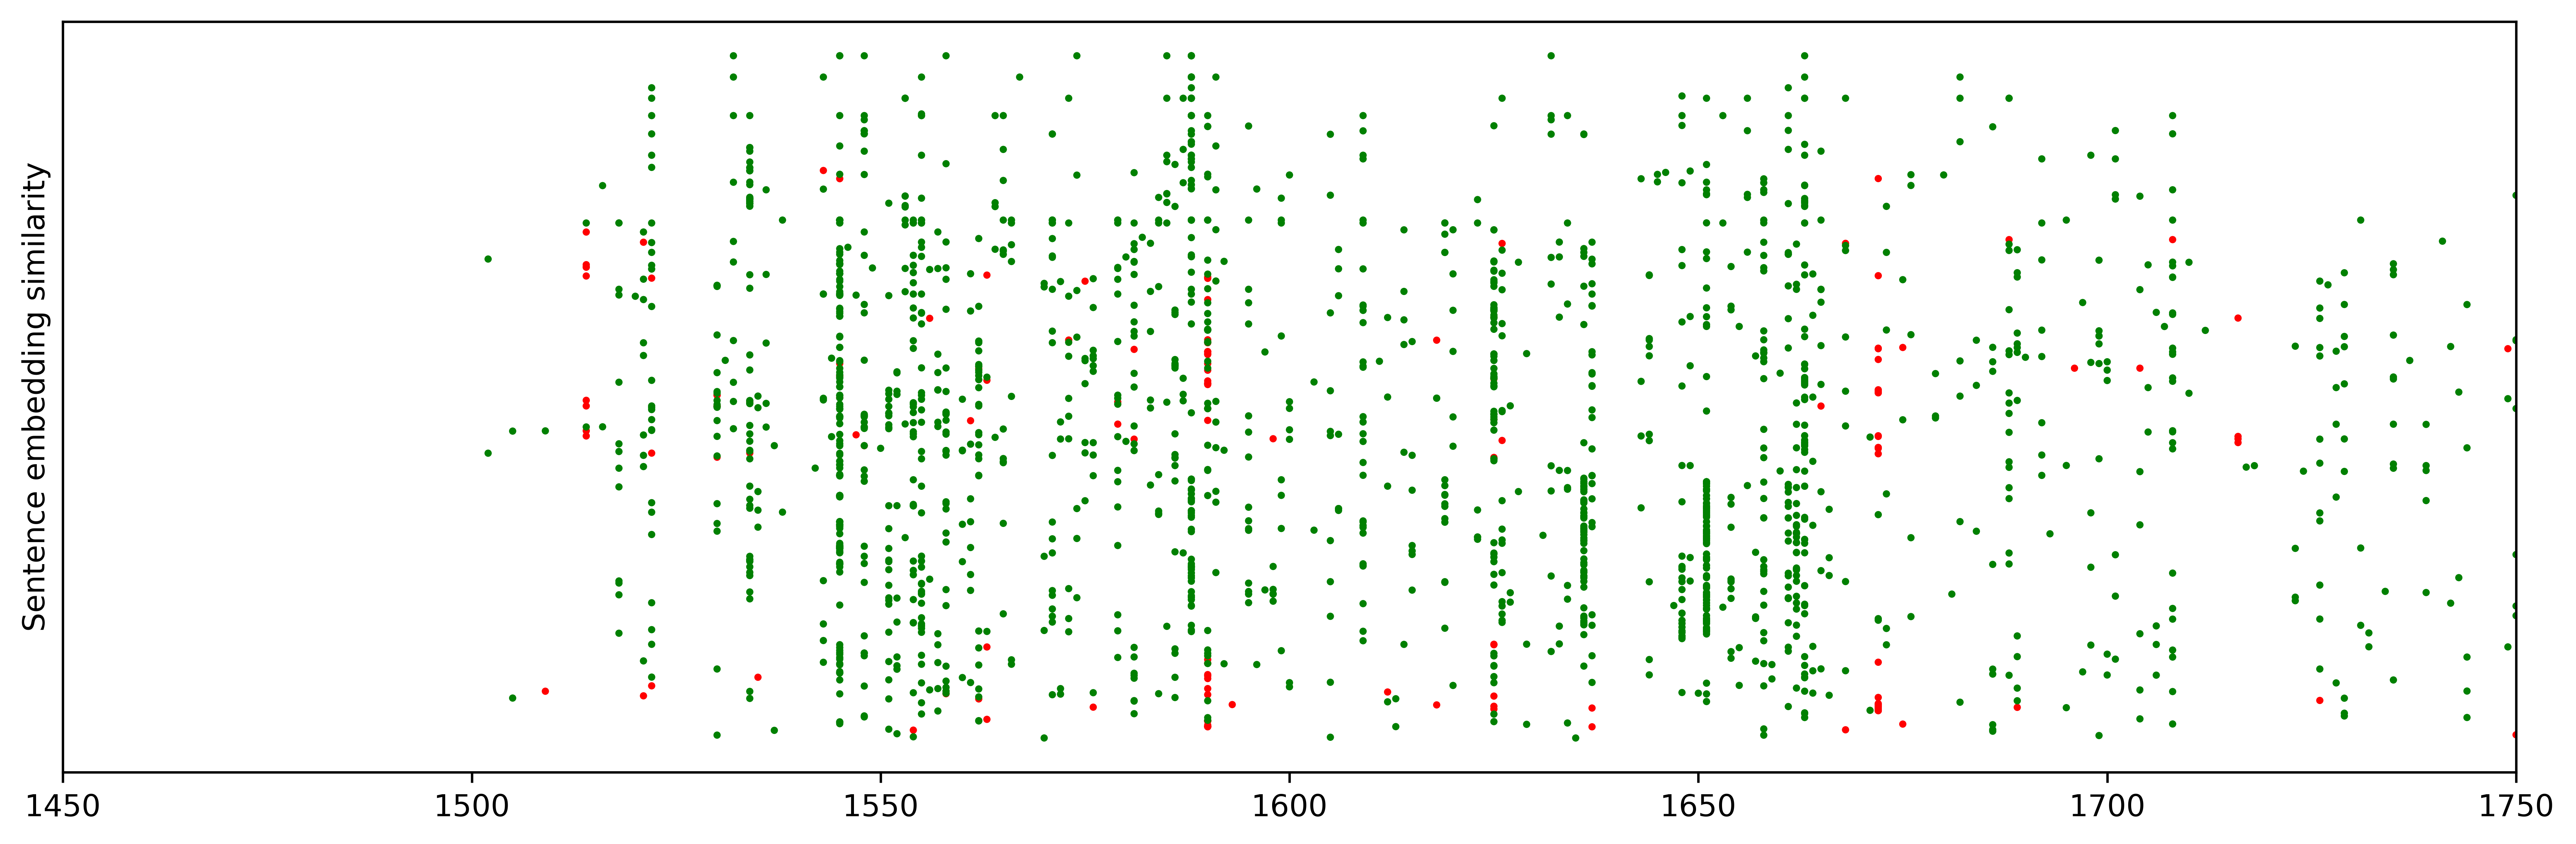

In [92]:
fig, ax = plt.subplots(tight_layout=True, dpi=600, figsize=(12,4))
ax.scatter(x=years, y=embeddings_tsne, c=colors, s=2)# You may want to adjust the size depending on your similarity matrix
ax.set_yticks([])
ax.set_ylabel("Sentence embedding similarity")
ax.set_xlim(1450, 1750)

In [103]:
xs = years
ys = [np.round(n, 2) for n in embeddings_tsne2d[:, 0]]
zs = [np.round(n, 2) for n in embeddings_tsne2d[:, 1]]

In [104]:
ys[:10]

[-5.07, 11.2, 3.38, 4.62, -9.27, 10.05, -14.05, -3.1, -27.66, -0.44]

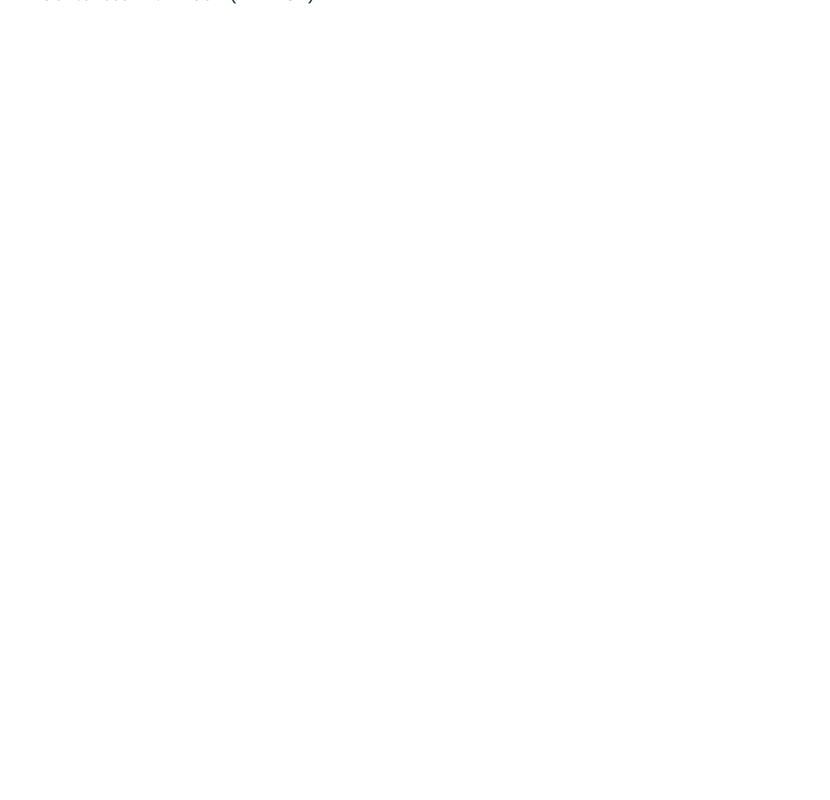

In [110]:
title = "Sentences with 'liber' (N={})".format(len(sentences))
fig = go.Figure(data=go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8
    ),
    text=hover_text,  # use mapped hover text
    hoverinfo='text',  # ensure only the text field is displayed on hover
))

fig.update_layout(
    title=title,
    scene=dict(
        xaxis=dict(title='year', showbackground=False, showgrid=True, showline=True), #showline=True, showticklabels=True, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        #xaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        yaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        zaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        bgcolor='rgba(255,255,255,0)'
    ),
    paper_bgcolor='rgba(255,255,255,255)',  # set the color of the area around the axes
    plot_bgcolor='rgba(255,255,255,255)',  # set the color of the entire chart
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


In [111]:
pio.write_html(fig, file="../figures/liber-diachronic.html")

In [112]:
#html_code = pio.to_html(fig, include_plotlyjs='cdn')
#pyperclip.copy(html_code)

In [113]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(target_embeddings)
labels = kmeans.labels_
cluster_colors = {0: "#1f77b4",  # muted blue
                  1: "#ff7f0e",  # safety orange
                  2: "#2ca02c",  # cooked asparagus green
                  3: "#d62728",  # brick red
                  4: "#9467bd"}
# colors = [cluster_colors[l] for l in labels]

In [114]:
tsne = TSNE(n_components=3, perplexity=30)
embeddings_tsne = tsne.fit_transform(np.vstack(target_vectors))

In [115]:
xs = embeddings_tsne[:, 0]
ys = embeddings_tsne[:, 1]
zs = embeddings_tsne[:, 2]

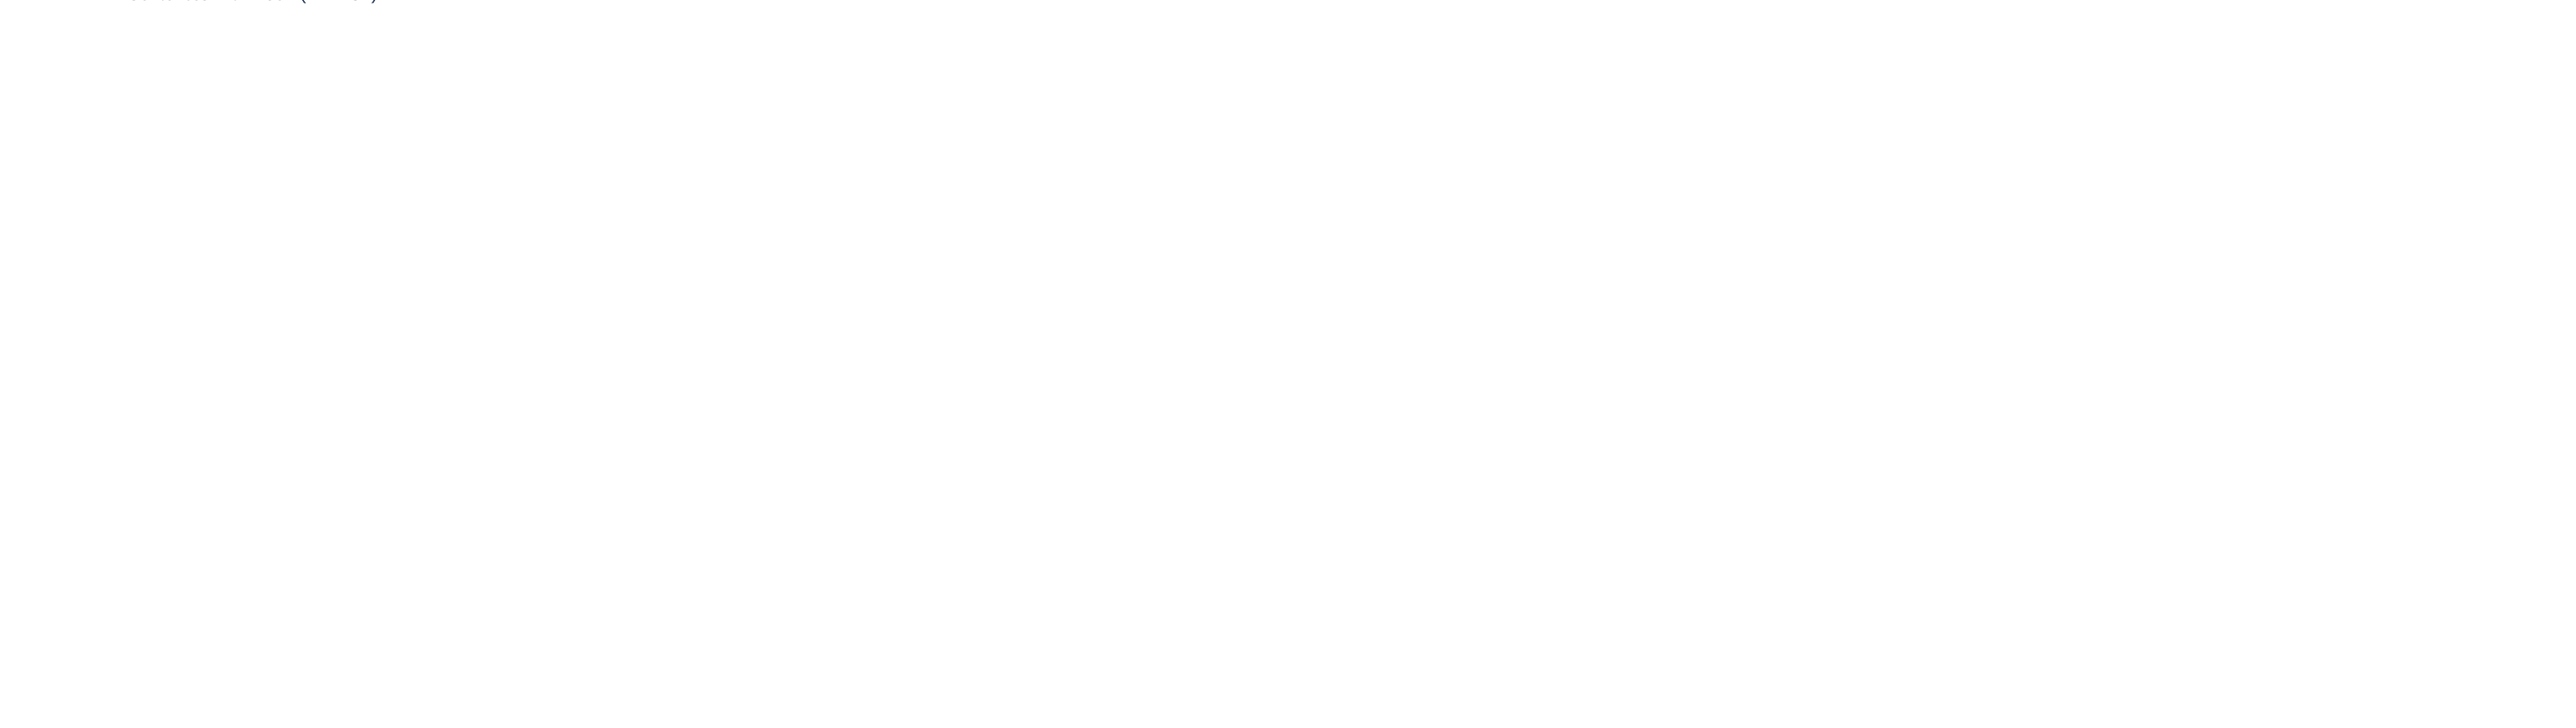

In [117]:
title = "Sentences with 'liber' (N={})".format(len(sentences))
fig = go.Figure(data=go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8
    ),
    text=hover_text,  # use mapped hover text
    hoverinfo='text',  # ensure only the text field is displayed on hover
))

fig.update_layout(
    title=title,
    scene=dict(
        xaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        yaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        zaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        bgcolor='rgba(255,255,255,0)'
    ),
    paper_bgcolor='rgba(255,255,255,255)',  # set the color of the area around the axes
    plot_bgcolor='rgba(255,255,255,255)',  # set the color of the entire chart
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


In [118]:
pio.write_html(fig, file="../figures/liber-sample.html")

In [73]:
#html_code = pio.to_html(fig, include_plotlyjs='cdn')
#pyperclip.copy(html_code)

In [119]:
len(sents_dfs)

2154

In [121]:
class_data = sents_dfs[:154] + random.sample(sents_dfs[154:], 346)

In [122]:
target = "liber"
target_vectors = []
for sent_data in class_data:
    df = sent_data[4]
    target_row = df.loc[df["spacy_lemma"] == target].iloc[0]
    target_vectors.append(target_row['bert_avg_emb'])

In [123]:
Y = 154 * [1] + 346 * [0] 

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [125]:
X_trainval, X_test, Y_trainval, Y_test = train_test_split(target_vectors, Y, test_size=0.2, random_state=42, stratify=Y)

In [126]:
# Split train into train-val
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, random_state=42,
                                                  stratify=Y_trainval)

In [127]:
model = LogisticRegression(max_iter=1000) # increasing max_iter to ensure convergence
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

print('Validation Accuracy: ', accuracy_score(Y_val, Y_pred))
print('\nClassification Report:\n', classification_report(Y_val, Y_pred))

Validation Accuracy:  0.9125

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93        55
           1       0.82      0.92      0.87        25

    accuracy                           0.91        80
   macro avg       0.89      0.91      0.90        80
weighted avg       0.92      0.91      0.91        80



[Text(0, 0.5, 'liber\n(random)'), Text(0, 1.5, 'liber\nnaturae')]

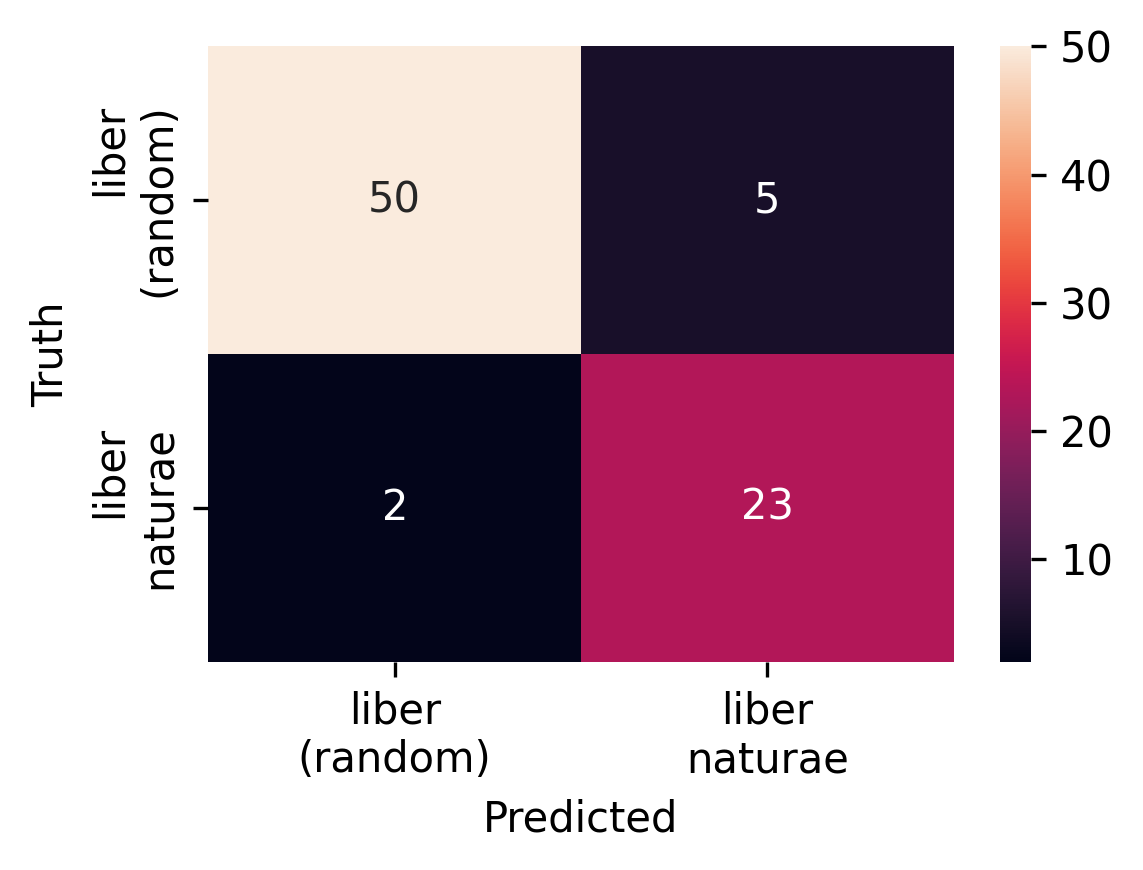

In [128]:
cm = confusion_matrix(Y_val, Y_pred)

fig, ax = plt.subplots(tight_layout=True, dpi=300, figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
ax.set_xticklabels(["liber\n(random)", "liber\nnaturae"])
ax.set_yticklabels(["liber\n(random)", "liber\nnaturae"])


In [129]:
fig.savefig("../figures/liber-confussion-matrix_v1.png")